# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. 
> Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. 

In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.

<img src="notebook_ims/vgg_16_architecture.png" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but **replace the final fully-connected layer** with our own classifier. This way we can use VGGNet as a _fixed feature extractor_ for our images then easily train a simple classifier on top of that. 
* Use all but the last fully-connected layer as a fixed feature extractor.
* Define a new, final classification layer and apply it to a task of our choice!

You can read more about transfer learning from [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).

---

## Flower power

Here we'll be using VGGNet to classify images of flowers. We'll start, as usual, by importing our usual resources. And checking if we can train our model on GPU.

### Download Data

Download the flower data from [this link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip), save it in the home directory of this notebook and extract the zip file to get the directory `flower_photos/`. **Make sure the directory has this exact name for accessing data: flower_photos**.

In [27]:
import os
import numpy as np
import torch
from torch import optim, nn
from torch_lr_finder import LRFinder
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class which makes it very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [4]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [5]:
# i want to apply a different transform to training and validation / test but i want my training data to be split
# into train and val
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(
                                          0, scale=(0.8, 1.2), shear=10),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ColorJitter(
                                          brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

val_and_test_transform = transforms.Compose([transforms.Resize((224,224)),
                                             transforms.ToTensor(),                                            
                                             transforms.Normalize((0.5,), (0.5,))])

In [6]:
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        # j'applique la transfo au premier élément mais pas au label
        return self.map(self.dataset[index][0]), self.dataset[index][1] 

    def __len__(self):
        return len(self.dataset)

In [7]:
np.random.seed(41)
# other way to split if i want to apply a different transformation to train and validation from a train dataset
train_and_val_data = datasets.ImageFolder(train_dir) # i don't apply a transform here
valid_size = 0.2
num_train = len(train_and_val_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_data = torch.utils.data.Subset(train_and_val_data, train_idx)
val_data = torch.utils.data.Subset(train_and_val_data, valid_idx)

train_data_tf = MapDataset(train_data,train_transform) 
val_data_tf = MapDataset(val_data,val_and_test_transform)

test_data = datasets.ImageFolder(test_dir, transform=val_and_test_transform) #standard method here 

In [8]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data_tf, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_data_tf, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False)

In [9]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #3*224*224
    
    image = image.transpose(1,2,0)
    image = image * np.array([0.5])+ np.array([0.5]) #reverse normalisation
    image.clip(0,1) #ensures range is between 0 and 1
    return image

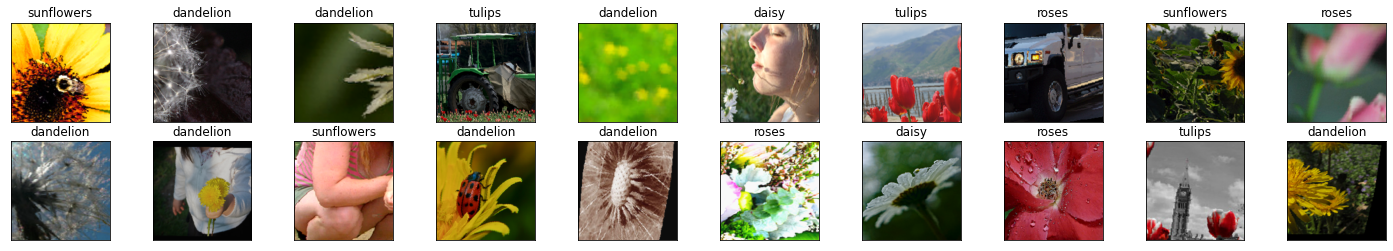

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks= [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [11]:
next(iter(train_data_tf)) # les données sont bien entre -1 et 1

(tensor([[[-0.9529, -0.9529, -0.9529,  ..., -0.3647, -0.3490, -0.3882],
          [-0.9529, -0.9529, -0.9529,  ..., -0.3804, -0.3490, -0.3490],
          [-0.9529, -0.9529, -0.9529,  ..., -0.3961, -0.3961, -0.3490],
          ...,
          [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
          [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
          [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529]],
 
         [[-0.9529, -0.9529, -0.9529,  ..., -0.4275, -0.4275, -0.4275],
          [-0.9529, -0.9529, -0.9529,  ..., -0.4275, -0.4118, -0.4353],
          [-0.9529, -0.9529, -0.9529,  ..., -0.4667, -0.4275, -0.3647],
          ...,
          [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
          [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
          [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529]],
 
         [[-0.9529, -0.9529, -0.9529,  ..., -0.7569, -0.7569, -0.7804],
          [-0.9529, -0.9529,

In [12]:
# print out some data stats
print('Num training images: ', len(train_data_tf))
print('Num val images: ', len(val_data_tf))
print('Num test images: ', len(test_data))

Num training images:  2504
Num val images:  626
Num test images:  540


### DataLoaders and Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

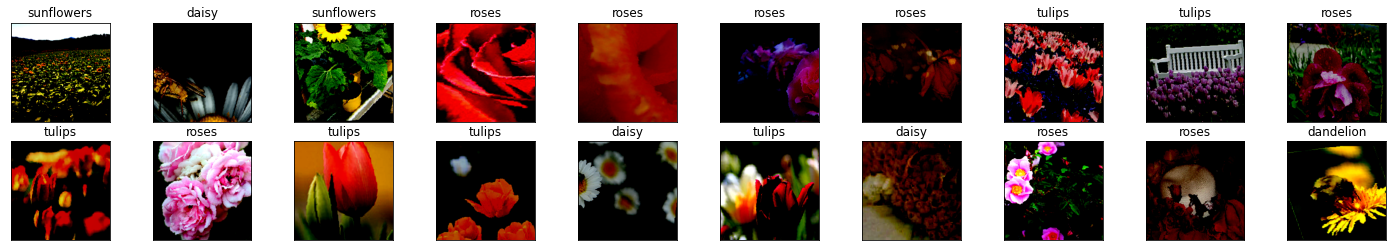

In [13]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [242]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [243]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 


4096
1000


In [244]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    

---
### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers. 
> This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

You can access any layer in a pretrained network by name and (sometimes) number, i.e. `vgg16.classifier[6]` is the sixth layer in a group of layers named "classifier".

#### TODO: Replace the last fully-connected layer with one that produces the appropriate number of class scores.

In [245]:
import torch.nn as nn## TODO: add a last linear layer  that maps n_inputs -> 5 flower classes
## new layers automatically have requires_grad = True

vgg16.classifier[6] = nn.Linear(4096,5) # j'aurais pu aussi définir un model avec init et forward à la place


# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

In [246]:
import inspect
inspect.getsource(vgg16.classifier[6].forward)

'    def forward(self, input):\n        return F.linear(input, self.weight, self.bias)\n'

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent with a small learning rate. Note that the optimizer accepts as input _only_ the trainable parameters `vgg.classifier.parameters()`.

In [247]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [248]:

lr_finder = LRFinder(vgg16, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr =1e-5, end_lr=1, num_iter=100)

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


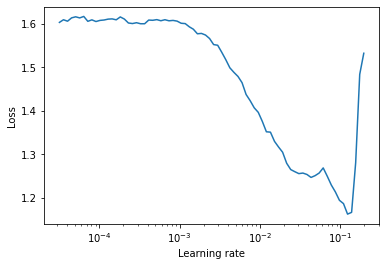

In [249]:
lr_finder.plot() # to inspect the loss-learning rate graph

In [250]:
lr_finder.reset() # to reset the model and optimizer to their initial state

In [251]:
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.05)

---
## Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [252]:
# number of epochs to train the model
n_epochs = 3

## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time
# 1 epoch avec le cpu = 40s contre 15s avec le gpu

running_loss_history = []
running_acc_history = []
val_running_loss_history = []
val_running_acc_history = []

vgg16.train()
for i in range(n_epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in train_loader: 

        inputs = inputs.cuda() # use gpu
        labels = labels.cuda()

       
        outputs = vgg16(inputs) 
        loss = criterion(outputs, labels) # see docs, it is normal, input is raw score and labels is class number of target. here loss is a minibatch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1) #preds is the index of the max value for the 100 images

        running_loss += loss.item()* inputs.size(0) # ma loss est moyennée donc je la multiplie par le nombre d'inputs
        running_corrects += torch.sum(preds == labels)
    else:
        with torch.no_grad():
            vgg16.eval()
        # no need to compute derivative on validation set so we save memory
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.cuda()
                val_labels = val_labels.cuda()
                val_outputs = vgg16(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs,1) #preds is the index of the max value for the 100 images
                val_running_loss += val_loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels)



    epoch_loss = running_loss/len(train_loader.dataset) # comme j'ai multiplié ma loss par inputs.size(0), je divise par le nombre dans le dataset
    epoch_acc = running_corrects/len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_acc_history.append(epoch_acc)
    print("training loss: {:4f}, accuracy : {:4f}".format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(val_loader.dataset) 
    val_epoch_acc = val_running_corrects/len(val_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_acc_history.append(val_epoch_acc)
    print("validation loss: {:4f}, accuracy : {:4f}".format(val_epoch_loss, val_epoch_acc.item()))



training loss: 0.766019, accuracy : 0.718450
validation loss: 0.148754, accuracy : 0.755591
training loss: 0.467784, accuracy : 0.825879
validation loss: 0.198472, accuracy : 0.750799
training loss: 0.384747, accuracy : 0.858227
validation loss: 0.092673, accuracy : 0.835463


In [254]:
torch.save({
            'model_state_dict': vgg16.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion': criterion,
            'losses': [running_loss_history, val_running_loss_history],
            'accuracy': [running_acc_history, val_running_acc_history],
    
            }, "model_state_1")

In [18]:
state1 = torch.load("model_state_1")
vgg16 = models.vgg16()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)
vgg16.classifier[6] = nn.Linear(4096,5)
vgg16.load_state_dict(state1['model_state_dict'])
optimizer.load_state_dict(state1['optimizer_state_dict'])
criterion = state1["criterion"]


running_loss_history = state1["losses"][0]
val_running_loss_history = state1["losses"][1]
running_acc_history = state1["accuracy"][0]
val_running_acc_history = state1["accuracy"][1]

In [20]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.05
    momentum: 0
    nesterov: False
    weight_decay: 0
)

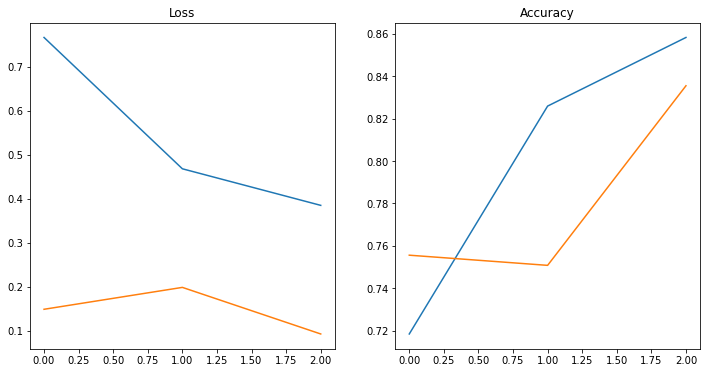

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(running_acc_history, label="training accuracy")
plt.plot(val_running_acc_history, label="validation accuracy")

In [28]:
for param in vgg16.parameters():
    param.requires_grad = False
#fine tuning for the whole classifier (we dont unfreeze the first layers because it is not needed here)
for param in vgg16.classifier.parameters():
    param.requires_grad = True

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


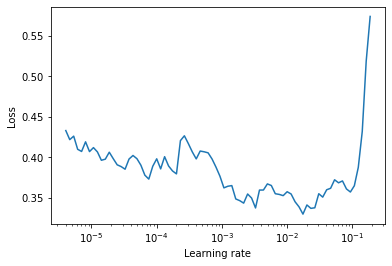

In [29]:
lr_finder = LRFinder(vgg16, optimizer, criterion, device="cuda")

lr_finder.range_test(train_loader, start_lr =1e-6, end_lr=1, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [32]:
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=9e-4)
vgg16 =vgg16.cuda()

In [33]:
# number of epochs to train the model
n_epochs = 2

## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time
# 1 epoch avec le cpu = 40s contre 15s avec le gpu

running_loss_history = []
running_acc_history = []
val_running_loss_history = []
val_running_acc_history = []

vgg16.train()
for i in range(n_epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in train_loader: 

        inputs = inputs.cuda() # use gpu
        labels = labels.cuda()

       
        outputs = vgg16(inputs) 
        loss = criterion(outputs, labels) # see docs, it is normal, input is raw score and labels is class number of target. here loss is a minibatch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1) #preds is the index of the max value for the 100 images

        running_loss += loss.item()* inputs.size(0) # ma loss est moyennée donc je la multiplie par le nombre d'inputs
        running_corrects += torch.sum(preds == labels)
    else:
        with torch.no_grad():
            vgg16.eval()
        # no need to compute derivative on validation set so we save memory
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.cuda()
                val_labels = val_labels.cuda()
                val_outputs = vgg16(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs,1) #preds is the index of the max value for the 100 images
                val_running_loss += val_loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels)



    epoch_loss = running_loss/len(train_loader.dataset) # comme j'ai multiplié ma loss par inputs.size(0), je divise par le nombre dans le dataset
    epoch_acc = running_corrects/len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_acc_history.append(epoch_acc)
    print("training loss: {:4f}, accuracy : {:4f}".format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(val_loader.dataset) 
    val_epoch_acc = val_running_corrects/len(val_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_acc_history.append(val_epoch_acc)
    print("validation loss: {:4f}, accuracy : {:4f}".format(val_epoch_loss, val_epoch_acc.item()))

training loss: 0.360797, accuracy : 0.861821
validation loss: 0.073201, accuracy : 0.865815
training loss: 0.271045, accuracy : 0.901358
validation loss: 0.073282, accuracy : 0.865815


---
## Testing

Below you see the test accuracy for each flower class.

In [34]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.409378

Test Accuracy of daisy: 96% (89/92)
Test Accuracy of dandelion: 92% (122/132)
Test Accuracy of roses: 64% (59/91)
Test Accuracy of sunflowers: 83% (84/101)
Test Accuracy of tulips: 77% (96/124)

Test Accuracy (Overall): 83% (450/540)


### Visualize Sample Test Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

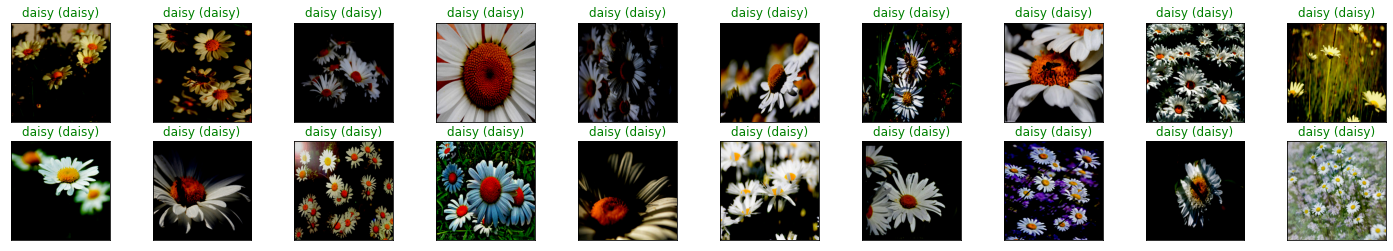

In [36]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))